In [1]:
import pandas as pd
import os
import numpy as np
import sys
from src.clustering import *
from src.visualization import *
import rdkit
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

## Loading Data

In [2]:
df = pd.read_csv('./init_data.csv')
df.head(3)

,index,file,mol,pdb_id,resolution,smiles,mol_weight
0,0,ligand_7PB_7VMG_D_D_502.pdb,7PB,7vmg,2.39,COc1cccc(Nc2cc(Nc3cccc(NC(=O)C4CC4)c3)ncn2)c1,375.424
1,1,ligand_LXL_5CA0_B_B_504.pdb,LXL,5ca0,2.50,CCC[C@H](Nc1nc(ncc1C)c2ccc(NC(=O)NCC)c(OC)c2)c...,434.534
2,2,ligand_EX5_6GF3_B_B_503.pdb,EX5,6gf3,2.40,CC[C@@]12CC(=C3Nc4cc(OC)c(OC(C)=O)cc4[C@@]35CC...,440.489


___

## Creating ECFP fingerprints

Loading strustures

In [3]:
compounds = []
for lig_name in df['file']:
    smiles = df.query('file == @lig_name')['smiles'].item()
    compounds.append((rdkit.Chem.rdmolfiles.MolFromPDBFile('/home/oem/research/colchicine_site/protein_prep/'+lig_name), lig_name, smiles))  # this structure will be used for visualization

Create fingerprints for all molecules (ECFP)

In [4]:
%%time
morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
fingerprints = [
    morgan_generator.GetFingerprint(mol)
    for mol, _, _ in compounds
    if mol is not None
]

CPU times: user 8.19 ms, sys: 76 μs, total: 8.27 ms
Wall time: 8.28 ms


In [5]:
# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))

Number of compounds converted: 146
Fingerprint length per compound: 2048


___

## Clustering Ligands by ECFP fingerprints

Plot several clusterings to choose the best cutoff (not shown here)

The number of clusters: 89 from 146 molecules at distance cut-off 0.40
The number of molecules in the largest cluster: 9
Average intra and inter cluster similarities: (0.6779940057794271, 0.1608061195333088)


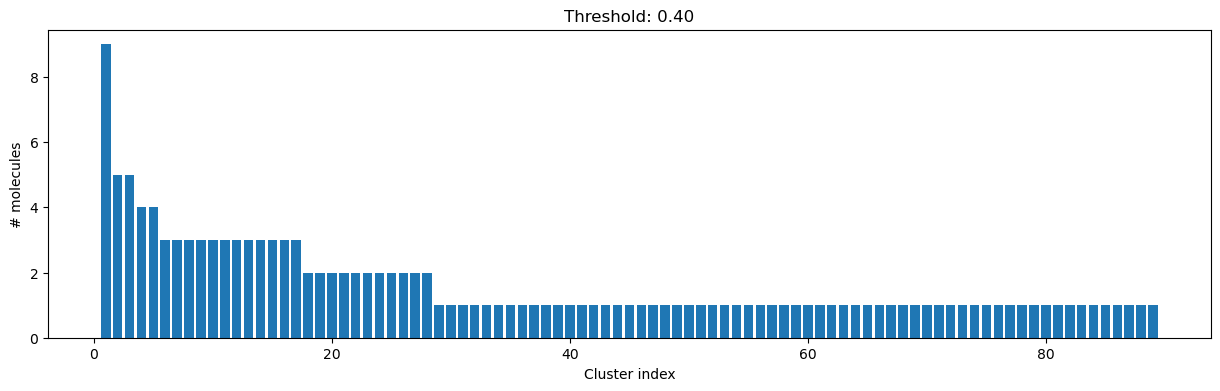

In [6]:
cutoff = 0.4
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.2f}")

print(
    f"The number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("The number of molecules in the largest cluster:", len(clusters[0]))
print(
    f"Average intra and inter cluster similarities: {compute_avg_similarities(clusters, fingerprints)}"
)

molecules from cluster 4:


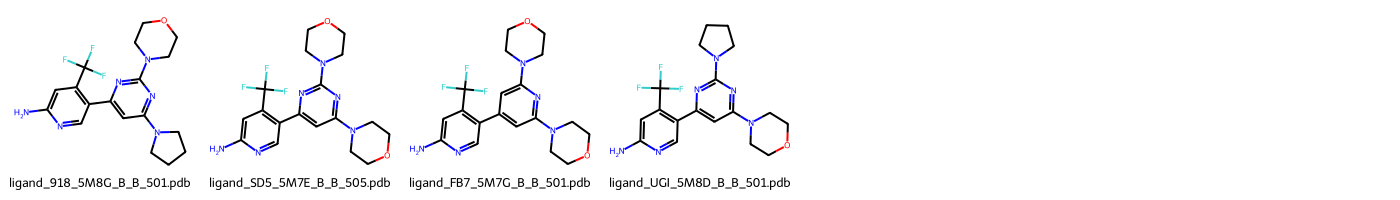

In [7]:
N = 4  # cluster number to visualize
print(f"molecules from cluster {N}:")
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(compounds[i][2]) for i in clusters[N][:30]],
    legends=[compounds[i][1] for i in clusters[N][:30]],
    molsPerRow=7, returnPNG=False, maxMols=160
)

## Creating a big picture of all clusters

In [8]:
gen_and_save_single_page_pdf(clusters, compounds)

I saved ./pics/clustering.pdf


## Saving cluster membership data to a table

In [9]:
# Создаём словарь: ключ = имя файла .pdb, значение = номер кластера
compound_to_cluster = {}

for n, cluster in enumerate(clusters):
    for ind in cluster:
        compound_name = compounds[ind][1]
        compound_to_cluster[compound_name] = n

# Предположим, в df есть колонка 'compound' с именами файлов
df['n_cluster'] = df['file'].map(compound_to_cluster)

In [10]:
df.head(3)

,index,file,mol,pdb_id,resolution,smiles,mol_weight,n_cluster
0,0,ligand_7PB_7VMG_D_D_502.pdb,7PB,7vmg,2.39,COc1cccc(Nc2cc(Nc3cccc(NC(=O)C4CC4)c3)ncn2)c1,375.424,10
1,1,ligand_LXL_5CA0_B_B_504.pdb,LXL,5ca0,2.50,CCC[C@H](Nc1nc(ncc1C)c2ccc(NC(=O)NCC)c(OC)c2)c...,434.534,88
2,2,ligand_EX5_6GF3_B_B_503.pdb,EX5,6gf3,2.40,CC[C@@]12CC(=C3Nc4cc(OC)c(OC(C)=O)cc4[C@@]35CC...,440.489,87


#### Let's add a column with information about the cluster centers (optional)

In [11]:
cl_centers = []
for _, cluster in enumerate(clusters):
    cl_centers.append(compounds[cluster[0]][1])

In [12]:
df['cl_center'] = df.index.isin(cl_centers)

## Splitting the dataset to keep cluster members in either training or test only

In [13]:
# Define the GroupKFold cross-validation iterator
n_splits = 5  # Define the number of folds for cross-validation
group_kfold = GroupKFold(n_splits=n_splits)
# Initialize a model (for example, Linear Regression)

for train_index, test_index in group_kfold.split(df, groups=df['n_cluster']):
    print('train N_clusters:', list(df['n_cluster'].iloc[train_index]))  
    print('test N_clusters:', list(df['n_cluster'].iloc[test_index])) 
    print('train shape:', len(train_index) / df.shape[0])
    print('test shape:', len(test_index) / df.shape[0])

    X_train = df.iloc[train_index].drop('mol_weight', axis=1)
    X_test = df.iloc[test_index].drop('mol_weight', axis=1)
    y_train = df['mol_weight'].iloc[train_index]
    y_test = df['mol_weight'].iloc[test_index]
    # Train the model    
    # Predict on the test set
    # Evaluate the model
    print('///////////////////////////////////////////////////////////////////////////')

train N_clusters: [10, 88, 87, 86, 2, 16, 1, 1, 85, 2, 83, 82, 81, 80, 78, 77, 76, 75, 73, 22, 72, 71, 21, 5, 5, 5, 17, 1, 1, 70, 16, 1, 6, 2, 26, 68, 67, 26, 15, 15, 15, 14, 11, 66, 19, 4, 4, 4, 4, 16, 25, 25, 64, 24, 24, 14, 63, 14, 62, 61, 12, 12, 2, 60, 58, 57, 56, 54, 9, 7, 13, 13, 13, 53, 7, 52, 51, 31, 6, 50, 12, 48, 47, 46, 45, 11, 11, 43, 17, 28, 41, 9, 10, 10, 30, 3, 3, 22, 9, 3, 3, 40, 21, 19, 39, 2, 7, 37, 36, 35, 34, 33, 18, 18, 29, 6]
test N_clusters: [23, 84, 79, 74, 8, 69, 27, 32, 27, 65, 23, 0, 0, 59, 55, 8, 0, 0, 49, 0, 44, 42, 0, 0, 0, 0, 20, 20, 8, 38]
train shape: 0.7945205479452054
test shape: 0.2054794520547945
///////////////////////////////////////////////////////////////////////////
train N_clusters: [87, 86, 2, 16, 23, 2, 84, 83, 82, 81, 79, 78, 77, 76, 74, 73, 22, 72, 71, 8, 17, 16, 69, 27, 32, 6, 2, 26, 68, 67, 27, 26, 14, 11, 66, 19, 4, 4, 4, 4, 65, 16, 25, 25, 24, 24, 14, 63, 14, 23, 62, 61, 12, 12, 0, 0, 2, 59, 58, 57, 56, 55, 8, 9, 7, 13, 13, 13, 53, 7,